In [1]:
# Must run this notebook from root directory in Anaconda for relative local file paths to work

Sys.time() # script start time

[1] "2018-08-10 12:27:37 AST"

# Install and attach packages

In [2]:
# See note at the end of this notebook regarding the preferred way of installing packages

In [3]:
library(tidyverse)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.4.1     v dplyr   0.7.4
v tidyr   0.7.2     v stringr 1.2.0
v readr   1.1.1     v forcats 0.2.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [4]:
library(data.table)


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last

The following object is masked from 'package:purrr':

    transpose



In [5]:
library(stringr)

In [6]:
library(gridExtra)


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [7]:
library(sf) # needed for mapping

Linking to GEOS 3.6.1, GDAL 2.2.0, proj.4 4.9.3


In [8]:
# install.packages("tmap")
# this for some reason can only be installed via install.packages(), but only has to be done once in your environment

In [9]:
library(tmap) # needed for mapping

In [10]:
# Set default options to display more digits, useful for gps coordinates

In [11]:
options(digits=15) # set the visible number of digits to 15, useful when displaying GIS coordinates in dataframes

In [12]:
options("digits") # display the max number of digits that appear in cells of a dataframe

$digits
[1] 15

In [13]:
sessionInfo()

R version 3.4.3 (2017-11-30)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 17134)

Matrix products: default

locale:
[1] LC_COLLATE=English_Canada.1252  LC_CTYPE=English_Canada.1252   
[3] LC_MONETARY=English_Canada.1252 LC_NUMERIC=C                   
[5] LC_TIME=English_Canada.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] tmap_1.10            sf_0.5-4             gridExtra_2.2.1     
 [4] data.table_1.10.4-3  forcats_0.2.0        stringr_1.2.0       
 [7] dplyr_0.7.4          purrr_0.2.4          readr_1.1.1         
[10] tidyr_0.7.2          tibble_1.4.1         ggplot2_2.2.1       
[13] tidyverse_1.2.1      RevoUtils_10.0.8     RevoUtilsMath_10.0.1

loaded via a namespace (and not attached):
  [1] colorspace_1.3-2   deldir_0.1-14      class_7.3-14      
  [4] gdalUtils_2.0.1.7  leaflet_1.1.0      rgdal_1.2-8       
  [7] satellite_1.0.0    IRdisplay_0.4.4   

# Main Script Begins Here

## 8. Suicide Rates for Females, 2016

In [14]:
Sys.time() # script start time from body

[1] "2018-08-10 12:27:46 AST"

In [15]:
# Import and clean data before analysis

In [16]:
# Import dataset
# Suicide rates in Canada
# Source: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1310080101


Sys.time() # start time for reading file
f <- function(x, pos) subset(x, 
                            !is.na(VALUE) # filter out any rows with missing values in the specified column in parenthesis
                            & Characteristics == "Percentage of deaths")
#                            & City == "Halifax") # only include rows where the specified condition is met
#                           & any other criteria for filtering
df <- read_csv_chunked("DataFilesCanadaProject/Suicide_Rates_2000_to_2016.csv", 
                           DataFrameCallback$new(f), 
                           chunk_size = 50000, # this is an adequate chunk size
                           col_names = TRUE,
                           cols_only( # specify which columns with data types you want to include 
                                      # to avoid importing unwanted data
                                      # include all columns that you specified above with col_names
                               "REF_DATE" = col_character(),
                               "GEO" = col_character(),
                               "Sex" = col_character(),
                               "Characteristics" = col_character(),
                               "Leading causes of death (ICD-10)" = col_character(),
                               "VALUE" = col_number()),
                           trim_ws = TRUE) # trim leading and trailing whitespace for each data point
Sys.time() # end time for reading file

[1] "2018-08-10 12:27:46 AST"

[1] "2018-08-10 12:27:47 AST"

In [17]:
glimpse(df)

Observations: 36,414
Variables: 6
$ REF_DATE                           <chr> "2000", "2000", "2000", "2000", ...
$ GEO                                <chr> "Canada, place of residence", "C...
$ Sex                                <chr> "Both sexes", "Both sexes", "Bot...
$ `Leading causes of death (ICD-10)` <chr> "Total, all causes of death", "S...
$ Characteristics                    <chr> "Percentage of deaths", "Percent...
$ VALUE                              <dbl> 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...


In [18]:
head(df)

REF_DATE,GEO,Sex,Leading causes of death (ICD-10),Characteristics,VALUE
2000,"Canada, place of residence",Both sexes,"Total, all causes of death",Percentage of deaths,100
2000,"Canada, place of residence",Both sexes,Salmonella infections,Percentage of deaths,0
2000,"Canada, place of residence",Both sexes,Shigellosis and amoebiasis,Percentage of deaths,0
2000,"Canada, place of residence",Both sexes,Tuberculosis,Percentage of deaths,0
2000,"Canada, place of residence",Both sexes,Whooping cough,Percentage of deaths,0
2000,"Canada, place of residence",Both sexes,Scarlet fever and erysipelas,Percentage of deaths,0


In [19]:
# Always rename the columns to remove spaces and special characters if you haven't already from read_csv_chunked
# This avoids any potential problems R may encounter with different packages if not taken care of properly right away

colnames(df) <- c("Year", "GEO", "Sex","CauseOfDeath", "Characteristics", "VALUE")

In [20]:
df$Year <- as.numeric(df$Year)
df$GEO <- as.factor(df$GEO)
df$Sex <- as.factor(df$Sex)
df$CauseOfDeath <- as.factor(df$CauseOfDeath)
df$Characteristics <- as.factor(df$Characteristics)

In [21]:
df

Year,GEO,Sex,CauseOfDeath,Characteristics,VALUE
2000,"Canada, place of residence",Both sexes,"Total, all causes of death",Percentage of deaths,100.0
2000,"Canada, place of residence",Both sexes,Salmonella infections,Percentage of deaths,0.0
2000,"Canada, place of residence",Both sexes,Shigellosis and amoebiasis,Percentage of deaths,0.0
2000,"Canada, place of residence",Both sexes,Tuberculosis,Percentage of deaths,0.0
2000,"Canada, place of residence",Both sexes,Whooping cough,Percentage of deaths,0.0
2000,"Canada, place of residence",Both sexes,Scarlet fever and erysipelas,Percentage of deaths,0.0
2000,"Canada, place of residence",Both sexes,Meningococcal infection,Percentage of deaths,0.0
2000,"Canada, place of residence",Both sexes,Sepsis,Percentage of deaths,0.6
2000,"Canada, place of residence",Both sexes,Syphilis,Percentage of deaths,0.0
2000,"Canada, place of residence",Both sexes,Acute poliomyelitis,Percentage of deaths,0.0


In [22]:
levels(df$CauseOfDeath)
levels(df$Sex)

[1] "Accidents (unintentional injuries)"                                                 
 [2] "Acute bronchitis and bronchiolitis"                                                 
 [3] "Acute poliomyelitis"                                                                
 [4] "Alzheimer's disease"                                                                
 [5] "Anaemias"                                                                           
 [6] "Aortic aneurysm and dissection"                                                     
 [7] "Arthropod-borne viral encephalitis"                                                 
 [8] "Assault (homicide)"                                                                 
 [9] "Atherosclerosis"                                                                    
[10] "Cerebrovascular diseases"                                                           
[11] "Certain conditions originating in the perinatal period"                             
[12] "Cholelithiasis and other disorders of gallbladder"                                  
[13] "Chronic liver disease and cirrhosis"                                                
[14] "Chronic lower respiratory diseases"                                                 
[15] "Complications of medical and surgical care"                                         
[16] "Congenital malformations, deformations and chromosomal abnormalities"               
[17] "Diabetes mellitus"                                                                  
[18] "Diseases of appendix"                                                               
[19] "Diseases of heart"                                                                  
[20] "Essential hypertension and hypertensive renal disease"                              
[21] "Hernia"                                                                             
[22] "Human immunodeficiency virus [HIV] disease"                                         
[23] "Hyperplasia of prostate"                                                            
[24] "In situ neoplasms, benign neoplasms and neoplasms of uncertain or unknown behaviour"
[25] "Infections of kidney"                                                               
[26] "Inflammatory diseases of female pelvic organs"                                      
[27] "Influenza and pneumonia"                                                            
[28] "Intentional self-harm (suicide)"                                                    
[29] "Legal intervention"                                                                 
[30] "Malaria"                                                                            
[31] "Malignant neoplasms"                                                                
[32] "Measles"                                                                            
[33] "Meningitis"                                                                         
[34] "Meningococcal infection"                                                            
[35] "Nephritis, nephrotic syndrome and nephrosis"                                        
[36] "Nutritional deficiencies"                                                           
[37] "Operations of war and their sequelae"                                               
[38] "Other causes of death"                                                              
[39] "Parkinson's disease"                                                                
[40] "Peptic ulcer"                                                                       
[41] "Pneumoconioses and chemical effects"                                                
[42] "Pneumonitis due to solids and liquids"                                              
[43] "Pregnancy, childbirth and the puerperium"                                           
[44] "Salmonella infections"                                                            

[1] "Both sexes" "Females"    "Males"

In [23]:
# drop the territories

df <- df %>%
  filter(Year == 2016) %>%
  filter(Sex == "Females") %>%
  filter(CauseOfDeath == "Intentional self-harm (suicide)")

glimpse(df)

Observations: 14
Variables: 6
$ Year            <dbl> 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 201...
$ GEO             <fctr> Canada, place of residence, Newfoundland and Labra...
$ Sex             <fctr> Females, Females, Females, Females, Females, Femal...
$ CauseOfDeath    <fctr> Intentional self-harm (suicide), Intentional self-...
$ Characteristics <fctr> Percentage of deaths, Percentage of deaths, Percen...
$ VALUE           <dbl> 0.8, 0.8, 0.2, 0.6, 0.7, 0.6, 0.8, 1.1, 1.2, 1.3, 0...


In [24]:
df

Year,GEO,Sex,CauseOfDeath,Characteristics,VALUE
2016,"Canada, place of residence",Females,Intentional self-harm (suicide),Percentage of deaths,0.8
2016,"Newfoundland and Labrador, place of residence",Females,Intentional self-harm (suicide),Percentage of deaths,0.8
2016,"Prince Edward Island, place of residence",Females,Intentional self-harm (suicide),Percentage of deaths,0.2
2016,"Nova Scotia, place of residence",Females,Intentional self-harm (suicide),Percentage of deaths,0.6
2016,"New Brunswick, place of residence",Females,Intentional self-harm (suicide),Percentage of deaths,0.7
2016,"Quebec, place of residence",Females,Intentional self-harm (suicide),Percentage of deaths,0.6
2016,"Ontario, place of residence",Females,Intentional self-harm (suicide),Percentage of deaths,0.8
2016,"Manitoba, place of residence",Females,Intentional self-harm (suicide),Percentage of deaths,1.1
2016,"Saskatchewan, place of residence",Females,Intentional self-harm (suicide),Percentage of deaths,1.2
2016,"Alberta, place of residence",Females,Intentional self-harm (suicide),Percentage of deaths,1.3


In [25]:
df$CauseOfDeath <- gsub(" ", "_", df$CauseOfDeath)
df$GEO <- gsub(" ", "_", df$GEO)
df$GEO <- gsub(",", "_", df$GEO)

In [26]:
df <- df %>% 
  spread(Characteristics, VALUE)

In [27]:
df

Year,GEO,Sex,CauseOfDeath,Percentage of deaths
2016,Alberta__place_of_residence,Females,Intentional_self-harm_(suicide),1.3
2016,British_Columbia__place_of_residence,Females,Intentional_self-harm_(suicide),0.7
2016,Canada__place_of_residence,Females,Intentional_self-harm_(suicide),0.8
2016,Manitoba__place_of_residence,Females,Intentional_self-harm_(suicide),1.1
2016,New_Brunswick__place_of_residence,Females,Intentional_self-harm_(suicide),0.7
2016,Newfoundland_and_Labrador__place_of_residence,Females,Intentional_self-harm_(suicide),0.8
2016,Northwest_Territories__place_of_residence,Females,Intentional_self-harm_(suicide),4.0
2016,Nova_Scotia__place_of_residence,Females,Intentional_self-harm_(suicide),0.6
2016,Nunavut__place_of_residence,Females,Intentional_self-harm_(suicide),8.0
2016,Ontario__place_of_residence,Females,Intentional_self-harm_(suicide),0.8


In [28]:
unique(df$GEO)

[1] "Alberta__place_of_residence"                  
 [2] "British_Columbia__place_of_residence"         
 [3] "Canada__place_of_residence"                   
 [4] "Manitoba__place_of_residence"                 
 [5] "New_Brunswick__place_of_residence"            
 [6] "Newfoundland_and_Labrador__place_of_residence"
 [7] "Northwest_Territories__place_of_residence"    
 [8] "Nova_Scotia__place_of_residence"              
 [9] "Nunavut__place_of_residence"                  
[10] "Ontario__place_of_residence"                  
[11] "Prince_Edward_Island__place_of_residence"     
[12] "Quebec__place_of_residence"                   
[13] "Saskatchewan__place_of_residence"             
[14] "Yukon__place_of_residence"

In [29]:
df_Provincial <- df

## Display a map of Canada showing results

In [30]:
CanadaMap <- st_read("GIS_Canada/lpr_000b16a_e.shp")

Reading layer `lpr_000b16a_e' from data source `C:\Users\rahmant\GIS_Canada\lpr_000b16a_e.shp' using driver `ESRI Shapefile'
Simple feature collection with 13 features and 6 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: 3689439 ymin: 659338.9 xmax: 9015737 ymax: 5242179
epsg (SRID):    NA
proj4string:    +proj=lcc +lat_1=49 +lat_2=77 +lat_0=63.390675 +lon_0=-91.86666666666666 +x_0=6200000 +y_0=3000000 +datum=NAD83 +units=m +no_defs


In [31]:
Sys.time()
glimpse(CanadaMap)
Sys.time()

[1] "2018-08-10 12:27:50 AST"

Observations: 13
Variables: 7
$ PRUID    <fctr> 10, 11, 12, 13, 24, 35, 46, 47, 48, 59, 60, 61, 62
$ PRNAME   <fctr> Newfoundland and Labrador / Terre-Neuve-et-Labrador, Prin...
$ PRENAME  <fctr> Newfoundland and Labrador, Prince Edward Island, Nova Sco...
$ PRFNAME  <fctr> Terre-Neuve-et-Labrador, Île-du-Prince-Édouard, Nouvelle-...
$ PREABBR  <fctr> N.L., P.E.I., N.S., N.B., Que., Ont., Man., Sask., Alta.,...
$ PRFABBR  <fctr> T.-N.-L., Î.-P.-É., N.-É., N.-B., Qc, Ont., Man., Sask., ...
$ geometry <simple_feature> MULTIPOLYGON (((8307365.588..., MULTIPOLYGON ((...


[1] "2018-08-10 12:28:14 AST"

In [32]:
# Sys.time()
# CanadaMap
# Sys.time()

In [33]:
# Add a column for PREABBR to df_Provincial in order to do a join with CanadaMap


df_Provincial$PREABBR <- NA

df_Provincial$PREABBR[df_Provincial$GEO == "Alberta__place_of_residence"] <- "Alta."
df_Provincial$PREABBR[df_Provincial$GEO == "British_Columbia__place_of_residence"] <- "B.C."
df_Provincial$PREABBR[df_Provincial$GEO == "Manitoba__place_of_residence"] <- "Man."
df_Provincial$PREABBR[df_Provincial$GEO == "New_Brunswick__place_of_residence"] <- "N.B."
df_Provincial$PREABBR[df_Provincial$GEO == "Newfoundland_and_Labrador__place_of_residence"] <- "N.L."
df_Provincial$PREABBR[df_Provincial$GEO == "Nova_Scotia__place_of_residence"] <- "N.S."
df_Provincial$PREABBR[df_Provincial$GEO == "Ontario__place_of_residence"] <- "Ont."
df_Provincial$PREABBR[df_Provincial$GEO == "Prince_Edward_Island__place_of_residence"] <- "P.E.I."
df_Provincial$PREABBR[df_Provincial$GEO == "Quebec__place_of_residence"] <- "Que."
df_Provincial$PREABBR[df_Provincial$GEO == "Saskatchewan__place_of_residence"] <- "Sask."



df_Provincial$PREABBR <- as.factor(df_Provincial$PREABBR)
glimpse(df_Provincial)
df_Provincial

Observations: 14
Variables: 6
$ Year                   <dbl> 2016, 2016, 2016, 2016, 2016, 2016, 2016, 20...
$ GEO                    <chr> "Alberta__place_of_residence", "British_Colu...
$ Sex                    <fctr> Females, Females, Females, Females, Females...
$ CauseOfDeath           <chr> "Intentional_self-harm_(suicide)", "Intentio...
$ `Percentage of deaths` <dbl> 1.3, 0.7, 0.8, 1.1, 0.7, 0.8, 4.0, 0.6, 8.0,...
$ PREABBR                <fctr> Alta., B.C., NA, Man., N.B., N.L., NA, N.S....


Year,GEO,Sex,CauseOfDeath,Percentage of deaths,PREABBR
2016,Alberta__place_of_residence,Females,Intentional_self-harm_(suicide),1.3,Alta.
2016,British_Columbia__place_of_residence,Females,Intentional_self-harm_(suicide),0.7,B.C.
2016,Canada__place_of_residence,Females,Intentional_self-harm_(suicide),0.8,NA
2016,Manitoba__place_of_residence,Females,Intentional_self-harm_(suicide),1.1,Man.
2016,New_Brunswick__place_of_residence,Females,Intentional_self-harm_(suicide),0.7,N.B.
2016,Newfoundland_and_Labrador__place_of_residence,Females,Intentional_self-harm_(suicide),0.8,N.L.
2016,Northwest_Territories__place_of_residence,Females,Intentional_self-harm_(suicide),4.0,NA
2016,Nova_Scotia__place_of_residence,Females,Intentional_self-harm_(suicide),0.6,N.S.
2016,Nunavut__place_of_residence,Females,Intentional_self-harm_(suicide),8.0,NA
2016,Ontario__place_of_residence,Females,Intentional_self-harm_(suicide),0.8,Ont.


In [34]:
colnames(df_Provincial) <- c("Year", "GEO", "Sex","CauseOfDeath", "PercentageOfDeaths", "PREABBR")

In [35]:
df_Provincial <- na.omit(df_Provincial)
glimpse(df_Provincial)
df_Provincial

Observations: 10
Variables: 6
$ Year               <dbl> 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, ...
$ GEO                <chr> "Alberta__place_of_residence", "British_Columbia...
$ Sex                <fctr> Females, Females, Females, Females, Females, Fe...
$ CauseOfDeath       <chr> "Intentional_self-harm_(suicide)", "Intentional_...
$ PercentageOfDeaths <dbl> 1.3, 0.7, 1.1, 0.7, 0.8, 0.6, 0.8, 0.2, 0.6, 1.2
$ PREABBR            <fctr> Alta., B.C., Man., N.B., N.L., N.S., Ont., P.E....


Year,GEO,Sex,CauseOfDeath,PercentageOfDeaths,PREABBR
2016,Alberta__place_of_residence,Females,Intentional_self-harm_(suicide),1.3,Alta.
2016,British_Columbia__place_of_residence,Females,Intentional_self-harm_(suicide),0.7,B.C.
2016,Manitoba__place_of_residence,Females,Intentional_self-harm_(suicide),1.1,Man.
2016,New_Brunswick__place_of_residence,Females,Intentional_self-harm_(suicide),0.7,N.B.
2016,Newfoundland_and_Labrador__place_of_residence,Females,Intentional_self-harm_(suicide),0.8,N.L.
2016,Nova_Scotia__place_of_residence,Females,Intentional_self-harm_(suicide),0.6,N.S.
2016,Ontario__place_of_residence,Females,Intentional_self-harm_(suicide),0.8,Ont.
2016,Prince_Edward_Island__place_of_residence,Females,Intentional_self-harm_(suicide),0.2,P.E.I.
2016,Quebec__place_of_residence,Females,Intentional_self-harm_(suicide),0.6,Que.
2016,Saskatchewan__place_of_residence,Females,Intentional_self-harm_(suicide),1.2,Sask.


In [36]:
# Before merging with a shapefile for polygon data, write the data to a table in csv format
# Table_B

write.csv(df_Provincial, 
          file = "Table_H.csv",
          row.names = FALSE) # set row.name to FALSE to not include an index column in the csv output file

In [37]:
# Save a dataframe as a nicely formatted png file
# uses the gridExtra package

png("Table_H.png", height = 30*nrow(df_Provincial), width = 150*ncol(df_Provincial))
grid.table(df_Provincial)
dev.off()

png 
  2

In [38]:
CanadaMap <- merge(CanadaMap, df_Provincial) # join the two dataframes, merge will use the common column name to join with

In [39]:
Sys.time()
glimpse(CanadaMap)
Sys.time()

[1] "2018-08-10 12:28:15 AST"

Observations: 10
Variables: 12
$ PREABBR            <fctr> Alta., B.C., Man., N.B., N.L., N.S., Ont., P.E....
$ PRUID              <fctr> 48, 59, 46, 13, 10, 12, 35, 11, 24, 47
$ PRNAME             <fctr> Alberta, British Columbia / Colombie-Britanniqu...
$ PRENAME            <fctr> Alberta, British Columbia, Manitoba, New Brunsw...
$ PRFNAME            <fctr> Alberta, Colombie-Britannique, Manitoba, Nouvea...
$ PRFABBR            <fctr> Alb., C.-B., Man., N.-B., T.-N.-L., N.-É., Ont....
$ Year               <dbl> 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, ...
$ GEO                <chr> "Alberta__place_of_residence", "British_Columbia...
$ Sex                <fctr> Females, Females, Females, Females, Females, Fe...
$ CauseOfDeath       <chr> "Intentional_self-harm_(suicide)", "Intentional_...
$ PercentageOfDeaths <dbl> 1.3, 0.7, 1.1, 0.7, 0.8, 0.6, 0.8, 0.2, 0.6, 1.2
$ geometry           <simple_feature> MULTIPOLYGON (((5228304.177..., MULTI...


[1] "2018-08-10 12:28:31 AST"

[1] "2018-08-10 12:28:31 AST"

[1] "2018-08-10 12:29:12 AST"

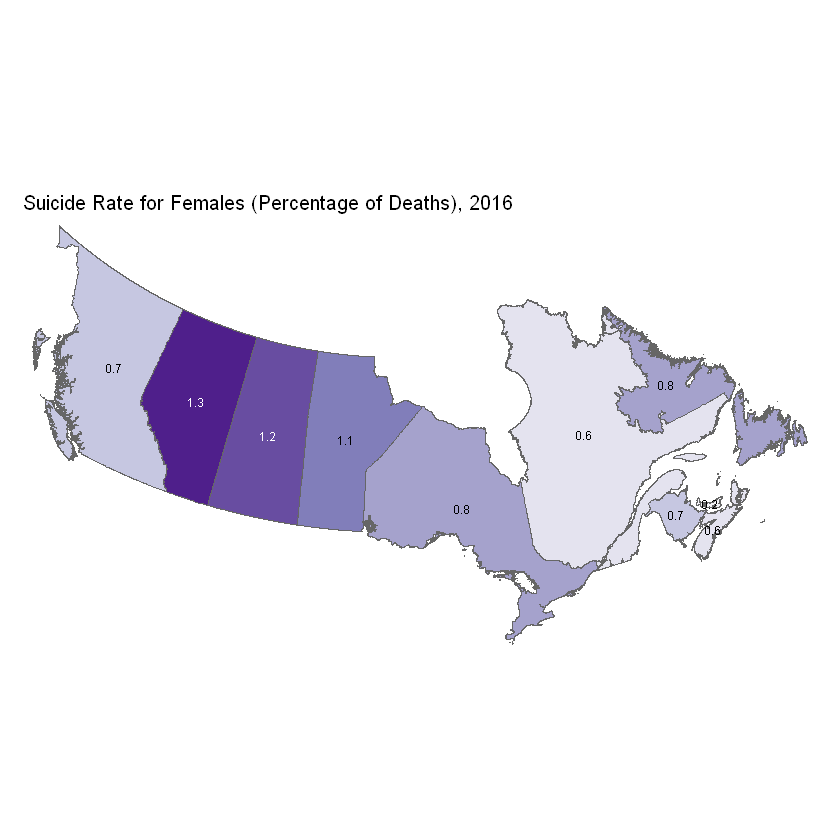

In [40]:
Sys.time()

my_map_H0 <-
  tm_shape(CanadaMap) +
  tm_polygons(col = "PercentageOfDeaths", palette = "Purples", style = "order") +
  tm_legend(legend.outside = TRUE, legend.outside.position = "bottom") +
  tm_text(text = "PercentageOfDeaths", size = .6) + 
  tm_layout(frame = FALSE, 
            legend.show = FALSE,
            main.title = "Suicide Rate for Females (Percentage of Deaths), 2016",
            main.title.size = 1)

my_map_H0

Sys.time()

In [41]:
# Sys.time()
#   save_tmap(tm = my_map_H0, 
#             filename = "Suicide Rate for Females (Percentage of Deaths), 2016.png")
# Sys.time()

# Main Script Ends Here

In [42]:
Sys.time()

[1] "2018-08-10 12:29:16 AST"

# Appendix 1 - Examples of common coding techniques

In [43]:
# Example of how to read and filter a large csv file a chunk at a time, e.g. filter 50000 rows at a time into a new dataframe
# This is very efficient, comparable to fread in speed but done in chunks to conserve memory
# I also prefer it to fread because I can filter out rows with missing values as I import the data
# and specify which columns I want to import 
# need readr library from tidyverse library


# Sys.time() # start time for reading file
# f <- function(x, pos) subset(x, 
#                             !is.na(Beds) # filter out any rows with missing values in the specified column in parenthesis
#                             & Gender == "Male") # only include rows where the specified condition is met
#                             & any other criteria for filtering
# df <- read_csv_chunked("http://www.edsc-esdc.gc.ca/ouvert-open/hps/CDHPD-OpenDataNSPL-DataSet-20170804-ENFR.csv", 
#                            DataFrameCallback$new(f), 
#                            chunk_size = 50000, # this is an adequate chunk size
#                            # col_names = TRUE # this will keep original column names if you don't provide custom names
#                                               # most of the time it's best to rename every column explicitly as shown below
#                            col_names = c("ShelterType", # this renames each column in order of the csv file to what you specify
#                                          "ProvinceCode",
#                                          "City",
#                                          "TargetPopulation",
#                                          "Gender",
#                                          "ShelterName",
#                                          "Beds"), # all other columns after this will be dropped if not included        
#                            cols_only( # specify which columns with data types you want to include 
#                                       # to avoid importing unwanted data
#                                       # include all columns that you specified above with col_names if you renamed them
#                                "ShelterType" = col_character(),
#                                "ProvinceCode" = col_character(),
#                                "City" = col_character(),
#                                "TargetPopulation" = col_character(),
#                                "Gender" = col_character(),
#                                "ShelterName" = col_character(),
#                                "Beds" = col_number()),
#                            skip = 1, # skip original column headers if you renamed them
#                            trim_ws = TRUE) # trim leading and trailing whitespace for each data point
# Sys.time() # end time for reading file

In [44]:
# Example of how to read csv files quickly with fread while converting all chr variables to factors 
# need data.table library
# Use fread when you are a lazy and know you won't have memory issues loading the entire dataset at once
# or when you know you need to keep all information loaded into memory

# df <- fread("DataFilesAOP/AB_Provincial_Detailed_Crime_Stats_2006-2011-2016.csv", 
#            stringsAsFactors = TRUE, header = TRUE)

In [45]:
# Example of how to write a dataframe to a csv file

# write.csv(df, 
#           file = "NS_Crime_Stats_Clean_Extract3.csv",
#           row.names = FALSE) # set row.name to FALSE to not include an index column in the csv output file

In [46]:
# Example how to change all of the column names in a dataframe to something friendlier
# You want to avoid special characters and spaces in column names to prevent problems with differnt packages and features
# Provide new names in a character vector

# colnames(df) <- c(" ", " ")

In [47]:
# Example how to set the number of digits displayed in dataframes

# options(digits=15) # set the visible number of digits to 15, useful when displaying GIS coordinates in dataframes
# options("digits") # display the max number of digits that appear in cells of a dataframe

In [48]:
# Example of how to convert columns to the correct data types and how to delete columns from a dataframe

# use as.numeric() and as.factor() where appropriate
# df$column_name <- NULL will delete that column from the dataframe

In [49]:
# Example of how to recode values of a column for rows meeting a condition

# df$LATITUDE[df$GEO == 
#                          "Amherst, Nova Scotia, municipal"] <- 45.8338198
# df$LONGITUDE[df$GEO == 
#                          "Amherst, Nova Scotia, municipal"] <- -64.2109455
#
# df$COUNTY[df$GEO ==
#                          "Amherst, Nova Scotia, municipal"] <- "Cumberland"

In [50]:
# Example of how to filter a dataframe to rows where a specific string appears anywhere in a specific column
# This example filters df to rows where "MEP" appears in the "Contents" column (need stringr library)

# df_MEP <- df %>%
#   filter(str_detect(Contents, "MEP"))

In [51]:
# Example of how to handle dates - converting from timestamp to YYYYMMDD
# This example is adequate if you really don't need a date field for arithmetic or plotting with ggplot2

# parse out date and time from Timestamp
# df <- 
#   separate(df, Timestamp, # e.g., "01/01/2017 12:00:00 AM"
#           into = c("Date", "Time", "AMPM"), sep = " ")

# parse out Month, Day, Year from Date
# df <- 
#  separate(df, Date, 
#           into = c("Month", "Day", "Year"), sep = "/")

# Remove unwanted columns
# df$Time <- NULL
# df$AMPM <- NULL

# unite the columns "Year", "Month", "Day" into a single column for "YYYYMMDD"
# df <- 
#  unite_(df, "YYYYMMDD", c("Year","Month", "Day"), sep = "")

# sort by date in decreasing order
# df <- df[order(df$YYYYMMDD, decreasing = TRUE), ]

In [52]:
# Use the lubridate library if arithmetic is important when working with date and time data
# In my opinion, the lubridate functions are more complicated than my current needs, so I prefer my approach above
# for handling dates/times

# https://lubridate.tidyverse.org/
# https://rawgit.com/rstudio/cheatsheets/master/lubridate.pdf

In [53]:
# Example of how to subset and retain only selected characters from a cell
# This is useful if you want to strip out useless characters in a cell given a start and end position to retain
# need stringr library

# df$gps <- 
#   str_sub(df$gps, start = 3, end = -2) 

# this gets rid of the first 3 characters and the last two characters
# you can get an accurate count of characters when viewing them with glimpse(df)

In [54]:
# Example how to merge two dataframes on common column names
# https://stackoverflow.com/questions/1299871/how-to-join-merge-data-frames-inner-outer-left-right

# CanadaMap <- merge(CanadaMap, df_Provincial) # join the two dataframes, merge will use the common column name to join with

In [55]:
# Example of how to combine two or more dataframes vertically with the same column names

# df4 <- rbind(df1, df2, df3)

In [56]:
# Example of how to combine two or more dataframes horizontally with the same number of rows but different columns

# df4 <- cbind(df1, df2, df3)

In [57]:
# Example of how to create a new column that takes on values by performing arithmetic on existing columns 
# need dplyr and tidyverse library
# This example creates a new column that divides one column by another and mutliplies the result by a constant

# NSMAP2011 <- NSMAP2011 %>%
#   mutate(PropertyCrimeCountyRatePer100K = PropertyCrimeIncidentsPerCounty/CountyPopulation * 100000)

In [58]:
# Example of how to order a dataframe by a column in descening order
# a "-" in front of the column name will sort it in descending (largest to lowest) order

# df <- 
#  df[with(df, order(-Incidents_Total)), ]


# adding multiple column names will prioritize ordering in that sequence

# df <- 
#  df[with(df, order(REGION, COUNTY, GEO, Violations, Statistics)), ]

#--------------------
# Alternatively, you can also use the following:
# sort by date in decreasing order
# df <- df[order(df$YYYYMMDD, decreasing = TRUE), ]

In [59]:
# Before spreading data for tidy format, make sure to remove any special characters beforehand
# This ensures that after spreading the data, the column names are all properly formatted
# Properly formatted column names will always appear flushed next to the dollar sign when glimpsing a dataframe
# If spaces or special characters are present in the column name, they will appear within single quotes after the dollar sign
# when glimpsing the dataframe after spreading the data

# df_health$Indicators <- gsub(" ", "_", df_health$Indicators)
# df_health$Indicators <- gsub(",", "", df_health$Indicators)
# df_health$Indicators <- gsub(";", "", df_health$Indicators)
# df_health$Indicators <- gsub("-", "_", df_health$Indicators)
# df_health$Indicators <- gsub("\\(", "", df_health$Indicators) # this removes left parenthesis
# df_health$Indicators <- gsub("\\)", "", df_health$Indicators) # this removes right parenthesis

# df_health <- df_health %>%
#   spread(Indicators, Value)

In [60]:
# Example how to set a cell as NA
# df_Provincial$PREABBR <- NA


# Example how to remove all rows with NA
# df_Provincial <- na.omit(df_Provincial)

In [61]:
# Example of how to load a shapefile for mapping 
# need sf library

# NS <- st_read("GIS_Nova_Scotia/Counties_GCS.shp")

In [62]:
# Example how to convert a dataframe of lats/longs to a an sf dataframe for points spatial data 
# need sf library

# pts <- st_as_sf(df, coords = c("LONGITUDE", "LATITUDE"), crs = 4269) # create sf object called "pts" from df
# class(pts)
# glimpse(pts) # LONGITUDE and LATITUDE columns are replaced with a geometry column for point data

In [63]:
# Example how to add custom icons for points spatial data 
# need sf library and tmap library

# Using custom icons for points instead of bubbles

# file <- "DataFilesGeneral/flower_960_720.png"  
# flower_icon <- tmap_icons(file, width = 48, height = 48, keep.asp = TRUE,
#   just = c("center", "center"), as.local = TRUE)

# my_map_2 <- my_map_0 +
#   tm_shape(pts) +
#   tm_symbols("VALUE", shape = flower_icon, size = .3, alpha = .2, border.alpha = 0) 
# my_map_2

# Appendix 2 - Note regarding preferred way for installing packages

In [64]:
# Preferrably, install new packages via Anaconda Prompt > conda install r-package_name
# Try to only use library() in notebook instead of install.packages()
# this is more reliable than using install.packages("package name") in R script
# Anaconda Prompt > conda list shows what packages are installed

# However, when the above isn't true for some reason, it is noted below
# e.g., tmap must be installed through install.packages("tmap")